### [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html)

O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet. Para criar uma SparkSession, use o seguinte padrão de construtor:

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

23/02/10 13:03:28 WARN Utils: Your hostname, DESKTOP-I8105PU resolves to a loopback address: 127.0.1.1; using 172.31.108.232 instead (on interface eth0)
23/02/10 13:03:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/02/10 13:03:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### **Carregamento dos Dados**

In [2]:
dados = spark.read.json(
    '../../data/imoveis.json'
)

In [3]:
dados

DataFrame[ident: struct<customerID:string,source:string>, listing: struct<address:struct<city:string,location:struct<lat:double,lon:double>,neighborhood:string,zone:string>,features:struct<bathrooms:bigint,bedrooms:bigint,floors:bigint,parkingSpaces:bigint,suites:bigint,totalAreas:string,unitFloor:bigint,unitsOnTheFloor:bigint,usableAreas:string>,prices:struct<price:string,tax:struct<condo:string,iptu:string>>,types:struct<unit:string,usage:string>>]

In [4]:
dados.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[775564-BOJSMVON, Website]|[[Rio de Janeiro, [-22.909429, -43.413557], Taquara, Zona Oeste], [0, 0, 0, 1, 0, 62, 0, 0, 62], [45000, [150, 0]], [Outros, Residencial]]                       |
|[660895-AUENKNYY, Website]|[[Rio de Janeiro, [-22.869698, -43.509141], Santíssimo, Zona Oeste], [1, 2, 0, 1, 0, 0, 0, 0, 44], [45000, [120, 0]], [Apartamento, Residencial]]                |
|[751522-JESYFEQL, Website]|[[Rio de Janeiro,

In [5]:
dados.count()

73615

## **Seleção de *Features***

In [6]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [7]:
dados\
    .select('ident.customerID', 'listing.*')\
    .show(truncate=False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+-------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices             |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+-------------------+--------------------------+
|775564-BOJSMVON|[Rio de Janeiro, [-22.909429, -43.413557], Taquara, Zona Oeste]                 |[0, 0, 0, 1, 0, 62, 0, 0, 62]  |[45000, [150, 0]]  |[Outros, Residencial]     |
|660895-AUENKNYY|[Rio de Janeiro, [-22.869698, -43.509141], Santíssimo, Zona Oeste]              |[1, 2, 0, 1, 0, 0, 0, 0, 44]   |[45000, [120, 0]]  |[Apartamento, Residencial]|
|751522-JESYFEQL|[Rio de Janeiro, [-22.986927, -43.646786], Pedra de Guaratiba, Zona Oeste]      |[0, 0, 0, 0,

### Refinando Seleção

In [8]:
dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|[-22.909429, -43.413557]|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [9]:
dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')\
    .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [10]:
dataset = dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')

### Tratamento de Dados

In [11]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [12]:
from pyspark.sql.types import IntegerType, DoubleType

In [13]:
dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))\
    .printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [14]:
dataset = dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))

In [15]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|  iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|   0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|  

In [16]:
dataset\
    .select('usage')\
    .groupBy('usage')\
    .count()\
    .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [17]:
dataset = dataset\
    .select('*')\
    .where('usage=="Residencial"')

In [18]:
dataset\
    .select('unit')\
    .groupBy('unit')\
    .count()\
    .show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [19]:
dataset\
    .select('zone')\
    .groupBy('zone')\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



### Tratamento para dados faltantes

[Functions](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions)


In [20]:
from pyspark.sql import functions as f

In [21]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [22]:
# Contagem de quantos registros nulos/na tenho no meu dataset
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

[Stage 39:===================================================>      (8 + 1) / 9]

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [23]:
# Substituindo valores nulos/na
dataset\
    .select('*')\
    .na\
    .fill(0)\
    .show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [24]:
dataset = dataset\
    .select('*')\
    .na\
    .fill(0)

In [25]:
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

[Stage 42:===================================================>      (8 + 1) / 9]

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [26]:
dataset\
    .select('zone')\
    .groupBy('zone')\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [27]:
# Remover dados com String vazia
dataset = dataset\
    .where(f.col('zone') != '')

## **Preparação dos Dados**

### Variáveis Dummy

Para modelos de regressão linear ele geralmente não trabalha com variáveis que são categóricas ou multicategórias, então transformamos em variáveis numéricas.

In [28]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [29]:
# representando as variáveis qualitativas de forma numérica
dataset\
    .groupBy("customerID")\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show()

[Stage 59:================================================>    (184 + 16) / 200]

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [30]:
unit = dataset\
    .groupBy('customerID')\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [31]:
zone = dataset\
    .groupBy('customerID')\
    .pivot('zone')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [32]:
dataset = dataset\
    .join(unit, 'customerID', how='inner')\
    .join(zone, 'customerID', how='inner')

In [33]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

### Vetorização dos Dados

Não podemos simplesmente jogar as variáveis no Dataset de um modelo de machine learning. O Spark não espera que façamos isso. Precisamos fazer a Vetorização dos dados, ou seja pegaremos todas as nossas colunas que são Dataset e as transformaremos em um vetor. As funções do Spark irão trabalhar com esse vetor.

In [34]:
from pyspark.ml.feature import VectorAssembler

In [35]:
# renomear a columa que iremos prever
dataset = dataset.withColumnRenamed('price','label')

In [36]:
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [37]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [38]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [39]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [40]:
dataset_prep.show(10, truncate=False)

23/02/10 13:04:04 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

## **Exploração dos Dados**

Vamos fazer uma exploração de dados, para verificar se existe uma correlação muito alta entre os dados do nosso modelo ou outro fato preocupante. Vamos correlacionar as variaveis.

In [41]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [42]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()

[Stage 97:===================================================>      (8 + 1) / 9]23/02/10 13:04:16 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/10 13:04:16 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [43]:
correlacao

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

In [44]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [45]:
correlacao

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

In [46]:
#Passar a matriz densa para um array
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [47]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

In [48]:
dataframe_correlacao

bathrooms  bedrooms    floors  parkingSpaces    suites  \
bathrooms         1.000000  0.665911 -0.044591       0.487590  0.752928   
bedrooms          0.665911  1.000000 -0.082184       0.467161  0.601199   
floors           -0.044591 -0.082184  1.000000      -0.048486 -0.048106   
parkingSpaces     0.487590  0.467161 -0.048486       1.000000  0.484988   
suites            0.752928  0.601199 -0.048106       0.484988  1.000000   
unitFloor         0.007624 -0.007162  0.120982       0.003768  0.005206   
unitsOnTheFloor  -0.107437 -0.130814  0.737717      -0.074527 -0.091914   
usableAreas       0.598073  0.563750 -0.103917       0.483732  0.577636   
condo             0.020030  0.018482  0.013797       0.018012  0.023461   
iptu              0.015102  0.013639  0.006688       0.009721  0.019093   
Apartamento      -0.275458 -0.258339  0.153947      -0.252746 -0.236217   
Casa              0.343042  0.349962 -0.142090       0.293326  0.282221   
Outros           -0.140183 -0.205608 -0.051946      -0.072359 -0.088834   
Zona Central     -0.097368 -0.123732  0.126044      -0.086437 -0.084417   
Zona Norte       -0.162497 -0.111712 -0.016926      -0.109957 -0.230317   
Zona Oeste        0.242345  0.163822 -0.031750       0.267990  0.327546   
Zona Sul         -0.098752 -0.049433  0.017402      -0.178807 -0.136398   

                 unitFloor  unitsOnTheFloor  usableAreas     condo      iptu  \
bathrooms         0.007624        -0.107437     0.598073  0.020030  0.015102   
bedrooms         -0.007162        -0.130814     0.563750  0.018482  0.013639   
floors            0.120982         0.737717    -0.103917  0.013797  0.006688   
parkingSpaces     0.003768        -0.074527     0.483732  0.018012  0.009721   
suites            0.005206        -0.091914     0.577636  0.023461  0.019093   
unitFloor         1.000000         0.092359    -0.012748  0.003065  0.001200   
unitsOnTheFloor   0.092359         1.000000    -0.144222 -0.000554  0.005029   
usableAreas      -0.012748        -0.144222     1.000000  0.019717  0.014656   
condo             0.003065        -0.000554     0.019717  1.000000  0.226212   
iptu              0.001200         0.005029     0.014656  0.226212  1.000000   
Apartamento       0.034674         0.147497    -0.482170  0.009105 -0.001502   
Casa             -0.031403        -0.137754     0.459136 -0.008624  0.002291   
Outros           -0.013275        -0.045523     0.125672 -0.002495 -0.001870   
Zona Central      0.022315         0.153639    -0.075256 -0.003553 -0.002438   
Zona Norte       -0.011112         0.030753    -0.158553 -0.013453 -0.008400   
Zona Oeste        0.007518        -0.012434     0.192466 -0.001055 -0.000428   
Zona Sul         -0.004333        -0.055540    -0.051962  0.014474  0.008835   

                 Apartamento      Casa    Outros  Zona Central  Zona Norte  \
bathrooms          -0.275458  0.343042 -0.140183     -0.097368   -0.162497   
bedrooms           -0.258339  0.349962 -0.205608     -0.123732   -0.111712   
floors              0.153947 -0.142090 -0.051946      0.126044   -0.016926   
parkingSpaces      -0.252746  0.293326 -0.072359     -0.086437   -0.109957   
suites             -0.236217  0.282221 -0.088834     -0.084417   -0.230317   
unitFloor           0.034674 -0.031403 -0.013275      0.022315   -0.011112   
unitsOnTheFloor     0.147497 -0.137754 -0.045523      0.153639    0.030753   
usableAreas        -0.482170  0.459136  0.125672     -0.075256   -0.158553   
condo               0.009105 -0.008624 -0.002495     -0.003553   -0.013453   
iptu               -0.001502  0.002291 -0.001870     -0.002438   -0.008400   
Apartamento         1.000000 -0.932270 -0.313032      0.034073    0.010312   
Casa               -0.932270  1.000000 -0.051751     -0.041823   -0.007961   
Outros             -0.313032 -0.051751  1.000000      0.015738   -0.007568   
Zona Central        0.034073 -0.041823  0.015738      1.000000   -0.061835   
Zona Norte          0.010312 -0.007961 -0.007568     -0

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

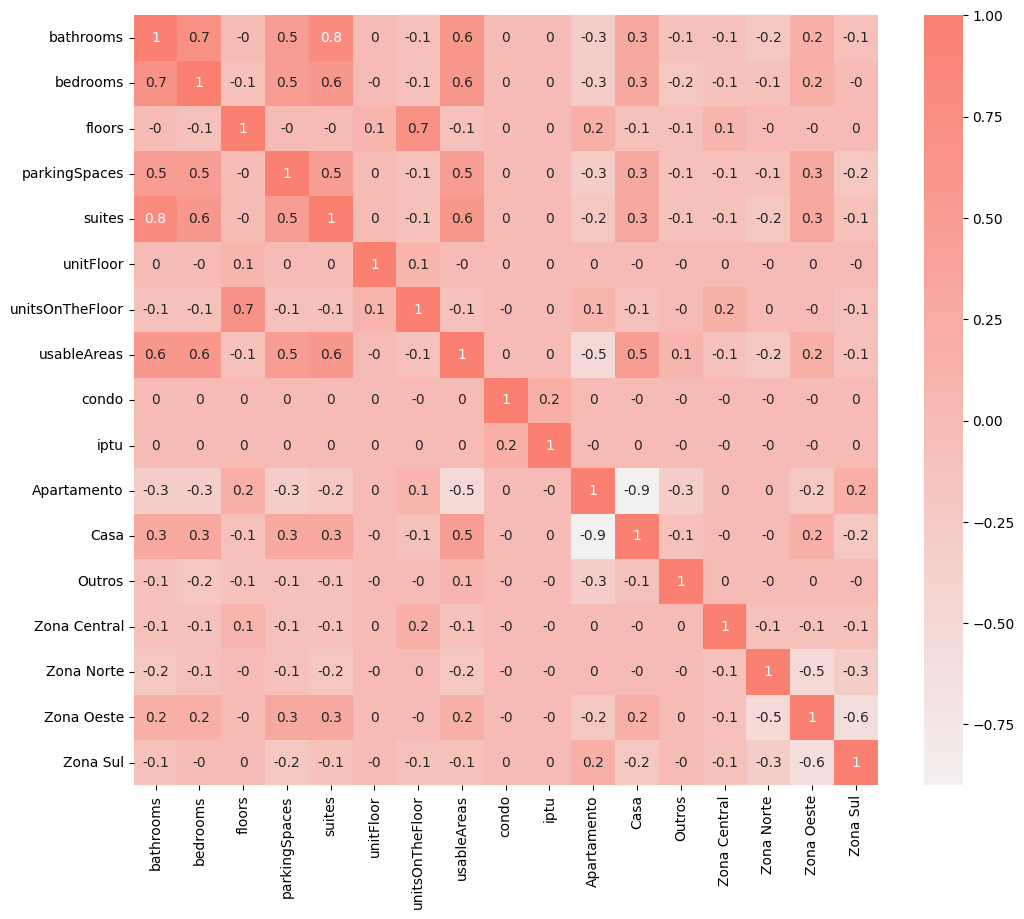

In [50]:
# Criar um mapa de calor para ter uma visualização melhor da correlação
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

## **Ajuste e Previsão**

<font size=2>**Documentação:**</font>
<font size=2>[randomSplit](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html)</font> |
<font size=2>[LinearRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html)</font>

Iniciar a construção do modelo

In [51]:
from pyspark.ml.regression import LinearRegression

In [52]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)

In [53]:
treino.count()

48649

In [54]:
teste.count()

20790

In [55]:
lr = LinearRegression()

In [56]:
modelo_lr = lr.fit(treino)

23/02/10 13:04:52 WARN Instrumentation: [df4fa0c2] regParam is zero, which might cause numerical instability and overfitting.
23/02/10 13:04:53 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/10 13:04:53 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/02/10 13:04:53 WARN Instrumentation: [df4fa0c2] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [57]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [58]:
previsoes_lr_treino.show()

[Stage 170:>                                                        (0 + 1) / 1]

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|454200.47020921746|
|(17,[0,1,2,3,4,5,...|500000.0|1150104.7801670646|
|(17,[0,1,2,3,4,5,...|308615.0|108560.91352150863|
|(17,[0,1,2,3,4,5,...|279000.0|119721.33389315562|
|(17,[0,1,2,3,4,5,...|199000.0|230637.07232407312|
|(17,[0,1,2,3,4,5,...|350000.0|  622290.819088955|
|(17,[0,1,2,3,4,5,...|449000.0|404520.71298834024|
|(17,[0,1,2,3,4,5,...|265000.0| 520694.7766535626|
|(17,[0,1,2,3,4,5,...|490000.0| 839190.6558716886|
|(17,[0,1,2,3,4,5,...|379900.0| 446773.3396354061|
|(17,[0,1,2,3,4,5,...|340000.0|514658.61578814447|
|(17,[0,1,2,3,4,5,...|430000.0|456426.87565495976|
|(17,[0,1,2,3,4,5,...|190000.0| 413365.5126902102|
|(17,[0,1,2,3,4,5,...|439000.0| 541021.1870499784|
|(17,[0,1,2,3,4,5,...|333000.0|  340639.650448495|
|(17,[0,1,2,3,4,5,...|948000.0| 608677.4666151265|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

Vamos extrair as metricas para verificar a performace do nosso modelo.
Iremos utiliza a metrica R2 que de modo simples é a diferença entre as amostras no conjunto de dados e as previsões feitas pelo modelo.
E tambem iremos, utilizar a metrica RMSE que nada mais é que a diferença entre o valor que foi previsto pelo seu modelo e o valor real que foi observado.

In [59]:
resumo_treino = modelo_lr.summary

In [60]:
resumo_treino.r2

0.6634244959626607

In [61]:
resumo_treino.rootMeanSquaredError

813341.9501053072

In [62]:
resumo_teste = modelo_lr.evaluate(teste)

In [63]:
resumo_teste.r2

0.6637736403772319

In [64]:
resumo_teste.rootMeanSquaredError

793330.9666494741

### **Tabela Resumo Regressão Linear**

In [65]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.663424
RMSE: 813341.950105

Dados de Teste
R²: 0.663774
RMSE: 793330.966649


# Fechamento Regressão Lienar #

## **Árvore de Decisão - Regressão**

**Hands ON**

<font size=2>**Documentação:**</font>
<font size=2>[DecisionTreeRegressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html)</font>

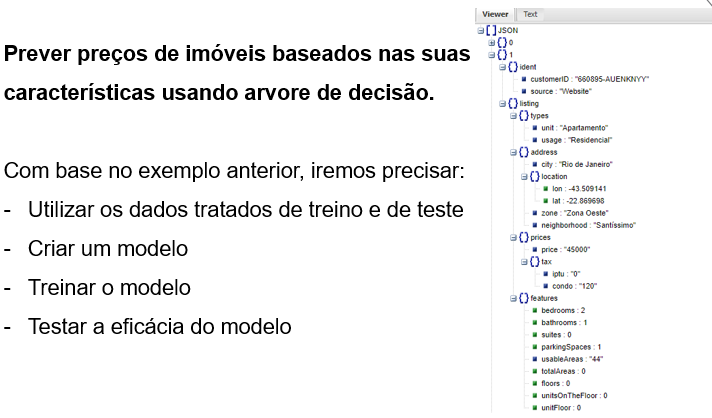(center)

## **Ajuste e Previsão**


In [66]:
from pyspark.ml.regression import DecisionTreeRegressor

In [67]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

In [68]:
modelo_dtr = dtr.fit(treino)

In [69]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [70]:
previsoes_dtr_treino.show()

[Stage 218:>                                                        (0 + 1) / 1]

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|500000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...|308615.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|279000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|199000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|350000.0| 840636.7992302758|
|(17,[0,1,2,3,4,5,...|449000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...|265000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...|490000.0| 840636.7992302758|
|(17,[0,1,2,3,4,5,...|379900.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|340000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...|430000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...|190000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|439000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...|333000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...|948000.0| 739321.4061522419|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

 
<font size=3>**Avaliador de Regressão**</font></br>
<font size=2>**Documentação:**</font>
<font size=2>[RegressionEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html)</font>

In [71]:
from pyspark.ml.evaluation import RegressionEvaluator

In [72]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.7905014269738377


[Stage 233:==================================================>      (8 + 1) / 9]

641685.8384764404


In [73]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [74]:
previsoes_dtr_teste.show()

[Stage 241:>                                                        (0 + 1) / 1]

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 545000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 479000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 420000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...| 650000.0| 739321.4061522419|
|(17,[0,1,2,3,4,5,...| 449000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 600000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...| 896000.0| 551532.7186434255|
|(17,[0,1,2,3,4,5,...| 679000.0|1164369.7816337426|
|(17,[0,1,2,3,4,5,...| 273944.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 447600.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 360000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 950000.0|1164369.7816337426|
|(17,[0,1,2,3,4,5,...|1400000.0|1238148.3897637795|
|(17,[0,1,2,3,4,5,...|1180000.0|1238148.3897637795|
|(17,[0,1,2,3,4,5,...| 620000.0|380098.47800052067|
|(17,[0,1,2,3,4,5,...| 279000.0|380098.47800052067|
|(17,[0,1,2,

In [75]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino


R²: 0.790501


RMSE: 641685.838476

Dados de Teste


R²: 0.767191


[Stage 272:==================================================>      (8 + 1) / 9]

RMSE: 660143.459559


## **Random Forest - Regressão**

### Random Forest

* Um modelo de Random Forest é uma técnica de aprendizado de máquina baseada em várias árvores de decisão.
* É uma forma de reduzir a variabilidade e melhorar a precisão do modelo de árvore de decisão individual.
* Ele funciona criando várias árvores de decisão, treinando cada árvore com um subconjunto aleatório dos dados e usando a média ou a votação para fazer previsões.

<img src='https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif'>

Como funciona um modelo de Random Forest para regressão?

* Em um problema de regressão, a tarefa é prever uma variável contínua (por exemplo, o preço de uma casa) com base em outras variáveis (por exemplo, tamanho da casa, localização, etc.).
* O modelo de Random Forest para regressão funciona criando várias árvores de decisão, como descrito acima.
* Cada árvore é treinada com um subconjunto aleatório dos dados e faz sua própria previsão.
* A previsão final é baseada na média ou na votação das previsões das várias árvores.

## **Ajuste e Previsão**

<font size=2>**Documentação:**</font>
<font size=2>[RandomForestRegressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html)</font>

In [76]:
from pyspark.ml.regression import RandomForestRegressor

In [77]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [78]:
modelo_rfr = rfr.fit(treino)

In [79]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [80]:
previsoes_rfr_treino.show()

[Stage 311:>                                                        (0 + 1) / 1]

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 404437.2516393555|
|(17,[0,1,2,3,4,5,...|500000.0| 510989.2447760013|
|(17,[0,1,2,3,4,5,...|308615.0| 379329.5314203141|
|(17,[0,1,2,3,4,5,...|279000.0| 379329.5314203141|
|(17,[0,1,2,3,4,5,...|199000.0| 379329.5314203141|
|(17,[0,1,2,3,4,5,...|350000.0| 846642.6918534003|
|(17,[0,1,2,3,4,5,...|449000.0| 505754.0475766345|
|(17,[0,1,2,3,4,5,...|265000.0| 525043.3944904088|
|(17,[0,1,2,3,4,5,...|490000.0| 846642.6918534003|
|(17,[0,1,2,3,4,5,...|379900.0| 436399.0422381066|
|(17,[0,1,2,3,4,5,...|340000.0| 525043.3944904088|
|(17,[0,1,2,3,4,5,...|430000.0| 554154.1620745151|
|(17,[0,1,2,3,4,5,...|190000.0|384564.72861968086|
|(17,[0,1,2,3,4,5,...|439000.0| 586211.1667851672|
|(17,[0,1,2,3,4,5,...|333000.0|384564.72861968086|
|(17,[0,1,2,3,4,5,...|948000.0| 608249.1787705355|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

In [81]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8075914773353434


[Stage 326:==================================================>      (8 + 1) / 9]

614956.0419025436


In [82]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [83]:
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 545000.0| 431163.8450387398|
|(17,[0,1,2,3,4,5,...| 479000.0|417109.69532433216|
|(17,[0,1,2,3,4,5,...| 420000.0| 609753.8028463412|
|(17,[0,1,2,3,4,5,...| 650000.0| 608249.1787705355|
|(17,[0,1,2,3,4,5,...| 449000.0|397237.17230465764|
|(17,[0,1,2,3,4,5,...| 600000.0| 554154.1620745151|
|(17,[0,1,2,3,4,5,...| 896000.0| 575275.2079755941|
|(17,[0,1,2,3,4,5,...| 679000.0| 980490.8809519218|
|(17,[0,1,2,3,4,5,...| 273944.0|384564.72861968086|
|(17,[0,1,2,3,4,5,...| 447600.0|384564.72861968086|
|(17,[0,1,2,3,4,5,...| 360000.0|384564.72861968086|
|(17,[0,1,2,3,4,5,...| 950000.0| 980490.8809519218|
|(17,[0,1,2,3,4,5,...|1400000.0|1400779.5143484017|
|(17,[0,1,2,3,4,5,...|1180000.0|1400779.5143484017|
|(17,[0,1,2,3,4,5,...| 620000.0| 372078.9097865656|
|(17,[0,1,2,3,4,5,...| 279000.0| 372078.9097865656|
|(17,[0,1,2,

In [84]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino


R²: 0.807591


RMSE: 614956.041903

Dados de Teste


R²: 0.791761


[Stage 365:==================================================>      (8 + 1) / 9]

RMSE: 624338.248432


## **Técnicas de Otimização**

### **Ferramentas**

### Cross Validation

Cross Validation é uma técnica utilizada na validação de modelos de aprendizado de máquina. O objetivo é avaliar a precisão e a capacidade geral do modelo ao longo do tempo. É usado para evitar o overfitting, ou seja, o modelo aprende demais dos dados de treinamento e não é capaz de generalizar bem para novos dados.

A Cross Validation funciona da seguinte maneira:

* Divida os dados em vários subconjuntos, conhecidos como folds.
* Treine o modelo com uma parte dos dados (normalmente 4 ou 5 folds) e valide-o com o fold restante.
* Repita esse processo para cada fold e calcule a média das métricas de desempenho, como acurácia ou erro quadrático médio.
* Escolha o modelo com as melhores métricas.
* A Cross Validation é uma maneira confiável de avaliar a precisão e a capacidade geral do modelo, pois considera vários subconjuntos de dados

<img src='https://miro.medium.com/max/1400/1*kkMtezwv8qj1t9uG4nw_8g.png'>

## **Árvore de Decisão com Cross Validation**

<font size=2>**Documentação:**</font>
<font size=2>[CrossValidator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)</font> |
<font size=2>[ParamGridBuilder](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)</font>

In [85]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [86]:
dtr = DecisionTreeRegressor()

In [87]:
# O parâmetro maxBins é a quantidade de vezes que a árvore de decisão tentará montar nós com diferentes condições 
# e o quão refinadas serão essas tentativas para que ela monte esses nós. 
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10]) \
    .addGrid(dtr.maxBins, [10, 32, 45]) \
    .build()

In [88]:
evaluator = RegressionEvaluator()

In [89]:
dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
    )

In [90]:
modelo_dtr_cv = dtr_cv.fit(treino)

In [91]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [92]:
print('Árvore de Decisão')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Árvore de Decisão
Sem Cross Validation


R²: 0.767191


RMSE: 660143.459559

Com Cross Validation


R²: 0.785156


[Stage 931:==================================================>      (8 + 1) / 9]

RMSE: 634162.026777


## **Random Forest com Cross Validation**


In [93]:
from pyspark.ml.regression import RandomForestRegressor

In [94]:
rfr = RandomForestRegressor()

In [95]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [96]:
evaluator = RegressionEvaluator()

In [97]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [98]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [99]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [100]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation


R²: 0.791761


RMSE: 624338.248432

Com Cross Validation


R²: 0.825627


[Stage 2224:=================================================>      (8 + 1) / 9]

RMSE: 571318.331958


### **Prevendo Resultados com o Melhor modelo**

In [101]:
dataset.show(15)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [102]:
# Variaveis que são usadas para prever no modelo
X

['bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [110]:
novo_imovel = [{
 'bathrooms': 2,
 'bedrooms': 1,
 'floors': 0,
 'parkingSpaces': 1,
 'suites': 1,
 'unitFloor':0,
 'unitsOnTheFloor':0,
 'usableAreas':150,
 'condo':200,
 'iptu':0,
 'Apartamento':1,
 'Casa':0,
 'Outros':0,
 'Zona Central':1,
 'Zona Norte':0,
 'Zona Oeste':0,
 'Zona Sul':0,
 'label': 0}]

In [111]:
meu_imovel = spark.createDataFrame(novo_imovel)

In [112]:
meu_imovel.show()

+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|bathrooms|bedrooms|condo|floors|iptu|label|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|          1|   0|     0|           1|         0|         0|       0|        2|       1|  200|     0|   0|    0|            1|     1|        0|              0|        150|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+



In [113]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [114]:
meu_lar_vetorizado = assembler.transform(meu_imovel).select('features', 'label')

In [115]:
meu_lar_vetorizado.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,3,4,7,8,...|    0|
+--------------------+-----+



In [116]:
modelo_rfr_cv.transform(meu_lar_vetorizado).show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|(17,[0,1,3,4,7,8,...|    0|816195.2970182231|
+--------------------+-----+-----------------+

